In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
from pandas.plotting import table

In [59]:
# Load data
df_auto = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t').astype('object')
df_single = pd.read_csv('./project_pipeline/data/single_domain_pae.tsv', sep='\t').astype('object')
df_multi = pd.read_csv('./project_pipeline/data/multi_domain_pae.tsv', sep='\t').astype('object')
cl = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

plt.style.use('ggplot')

Reformat the dataframes

In [60]:
df_pae = df_auto[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']]

# Remove all rows with multiple regions. Comment this out if you want to see the difference.
for i in range(len(df_single)):
    region = df_single.loc[i, 'region']
    count = region.count('-')
    if count > 1:
        df_single = df_single.drop(i)


# Reformat the singles dataframe
df_single = df_single[['uniprot', 'mean_pae']].dropna()
df_single = df_single.astype({'mean_pae': 'float'})
df_single = df_single.rename(columns={'mean_pae': 'Single Domain'})
df_single_melt = df_single.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')

# Reformat all pae dataframe
df_pae = df_pae.rename(columns={'mean_pae_1_1': 'IM-IM', 'mean_pae_1_2': 'IM-FD', 'mean_pae_2_2': 'FD-FD'})
df_pae_melt = df_pae.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').drop_duplicates()

# Reformat the multi dataframe
df_multi = df_multi[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_multi = df_multi.rename(columns={'mean_pae_1_1': 'D1-D1', 'mean_pae_1_2': 'D1-D2', 'mean_pae_2_2': 'D2-D2'})
df_multi_melt = df_multi.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').drop_duplicates()

# Add type column
df_pae_melt['type'] = 'Autoinhibitory'
df_single_melt['type'] = 'Single Domain'
df_multi_melt['type'] = 'Two-Domain'

# Merge all dataframes
df_all = pd.concat([df_single_melt, df_pae_melt, df_multi_melt], ignore_index=True).drop_duplicates()
df_all['mean_pae'] = df_all['mean_pae'].astype('float')

,uniprot,region,mean_pae,type
0,P03372,Single Domain,4.421,Single Domain
1,P00533,Single Domain,5.973,Single Domain
2,P03069,Single Domain,4.649,Single Domain
3,Q00987,Single Domain,2.809,Single Domain
4,P00974,Single Domain,1.399,Single Domain
...,...,...,...,...
784,Q63QJ1,D2-D2,4.006,Two-Domain
785,Q8KHY3,D2-D2,2.490,Two-Domain
786,Q2TU34,D2-D2,1.892,Two-Domain
787,B7LGE4,D2-D2,1.463,Two-Domain


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM-FD_Autoinhibitory vs. IM-IM_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided, P_val:7.968e-14 U_stat=1.173e+04
IM-IM_Autoinhibitory vs. FD-FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided, P_val:4.357e-01 U_stat=8.000e+03
D1-D2_Two-Domain vs. D1-D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.595e-07 U_stat=2.312e+03
D1-D1_Two-Domain vs. D2-D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:6.310e-03 U_stat=1.903e+03
IM-FD_Autoinhibitory vs. FD-FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided, P_val:3.580e-19 U_stat=1.256e+04
D1-D2_Two-Domain vs. D2-D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.515e-13 U_stat=2.650e+03


(<Axes: title={'center': 'Average PAE Across Domains'}, xlabel='Domains Compared', ylabel='Average PAE'>,
  <statannotations.Annotation.Annotation at 0x7fa6cd09c0d0>])

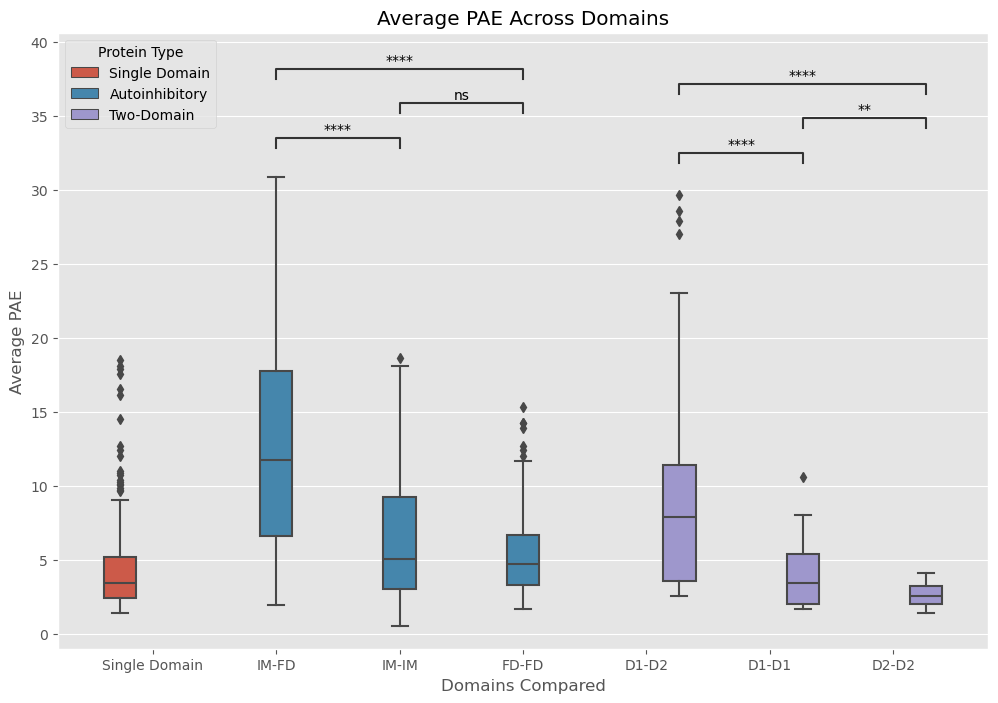

In [61]:
region_order = ['Single Domain', 'IM-FD', 'IM-IM', 'FD-FD', 'D1-D2', 'D1-D1', 'D2-D2']

f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_all, x='region', y='mean_pae', hue='type', order=region_order, ax=ax)
ax.set_xlabel('Domains Compared')
ax.set_ylabel('Average PAE')
ax.set_title('Average PAE Across Domains')
ax.legend(title='Protein Type')

plt.savefig('./project_pipeline/data/figures/auto_sd_md_proteins_pae.png')

# Annotate statistical significance

pairs = [[('IM-FD', 'Autoinhibitory'), ('IM-IM', 'Autoinhibitory')],
         [('IM-FD', 'Autoinhibitory'), ('FD-FD', 'Autoinhibitory')],
         [('IM-IM', 'Autoinhibitory'), ('FD-FD', 'Autoinhibitory')],
         [('D1-D2', 'Two-Domain'), ('D1-D1', 'Two-Domain')],
         [('D1-D2', 'Two-Domain'), ('D2-D2', 'Two-Domain')],
         [('D1-D1', 'Two-Domain'), ('D2-D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_all, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

We're going to slightly change the order

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D2-D2_Two-Domain vs. FD-FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.163e-13 U_stat=9.430e+02
D1-D1_Two-Domain vs. IM-IM_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.840e-03 U_stat=2.188e+03
D1-D2_Two-Domain vs. IM-FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.845e-03 U_stat=2.249e+03
Single Domain_Single Domain vs. D2-D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.899e-05 U_stat=9.776e+03
Single Domain_Single Domain vs. FD-FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.941e-05 U_stat=1.119e+04
Single Domain_Single Domain vs. D1-D1_Two-Domain: Mann-Whitney-Wilcoxon test two-side

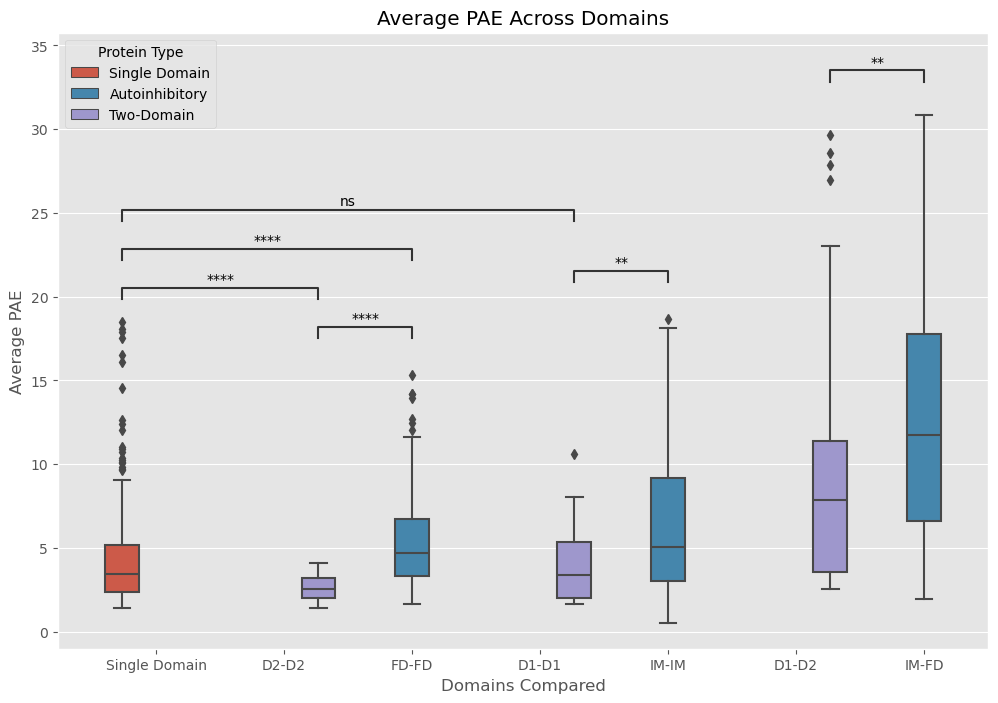

In [62]:
region_order = ['Single Domain', 'D2-D2', 'FD-FD', 'D1-D1', 'IM-IM', 'D1-D2', 'IM-FD']

f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_all, x='region', y='mean_pae', hue='type', order=region_order, ax=ax)
ax.set_xlabel('Domains Compared')
ax.set_ylabel('Average PAE')
ax.set_title('Average PAE Across Domains')
ax.legend(title='Protein Type')

plt.savefig('./project_pipeline/data/figures/auto_sd_md_proteins_pae.png')

# Annotate statistical significance

pairs = [[('Single Domain', 'Single Domain'), ('FD-FD', 'Autoinhibitory')],
         [('Single Domain', 'Single Domain'), ('D2-D2', 'Two-Domain')],
         [('Single Domain', 'Single Domain'), ('D1-D1', 'Two-Domain')],
         [('FD-FD', 'Autoinhibitory'), ('D2-D2', 'Two-Domain')],
         [('IM-IM', 'Autoinhibitory'), ('D1-D1', 'Two-Domain')],
         [('IM-FD', 'Autoinhibitory'), ('D1-D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_all, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="bonferroni")
_, corrected_results = annotator.apply_and_annotate()

We'll make a table for all the types of our proteins. 

Single Domain     258
Autoinhibitory    123
Two-Domain         54
Name: type, dtype: int64


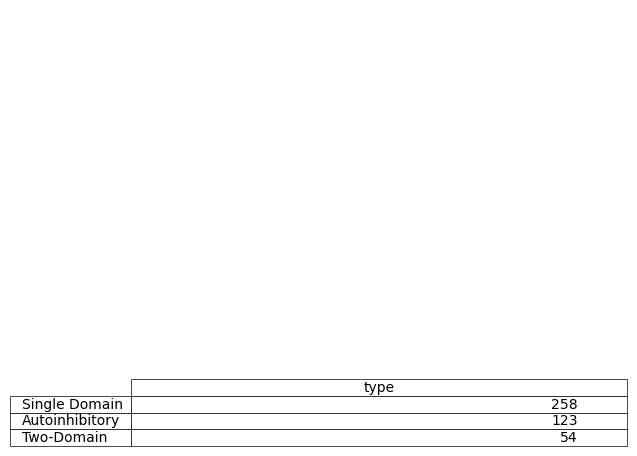

In [76]:
subAll = df_all[['uniprot', 'type']]
subAll = subAll.drop_duplicates()

# Get the number of proteins in each category
counts = subAll['type'].value_counts()
print(counts)

ax = plt.subplot(111, frame_on=False)
table(ax, counts)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

Now we're going to look at proteins with both states.

In [65]:
# Determine which proteins from cl have both active and autoinhibited structures
both = cl.groupby('uniprot').filter(lambda x: x['state'].nunique() > 1)

# Get the list of uniprots
uniprots = both['uniprot'].unique()

# Filter for these proteins in the pae dataframe
df_both_melt = df_pae_melt[df_pae_melt['uniprot'].isin(uniprots)]

# Merge the dataframes
df_all2 = pd.concat([df_single_melt, df_both_melt, df_multi_melt], ignore_index=True).drop_duplicates()
df_all2['mean_pae'] = df_all2['mean_pae'].astype('float')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D2-D2_Two-Domain vs. FD-FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.163e-13 U_stat=9.430e+02
D1-D1_Two-Domain vs. IM-IM_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.840e-03 U_stat=2.188e+03
D1-D2_Two-Domain vs. IM-FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.845e-03 U_stat=2.249e+03
Single Domain_Single Domain vs. D2-D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.899e-05 U_stat=9.776e+03
Single Domain_Single Domain vs. FD-FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.941e-05 U_stat=1.119e+04
Single Domain_Single Domain vs. D1-D1_Two-Domain: Mann-Whitney-Wilcoxon test two-side

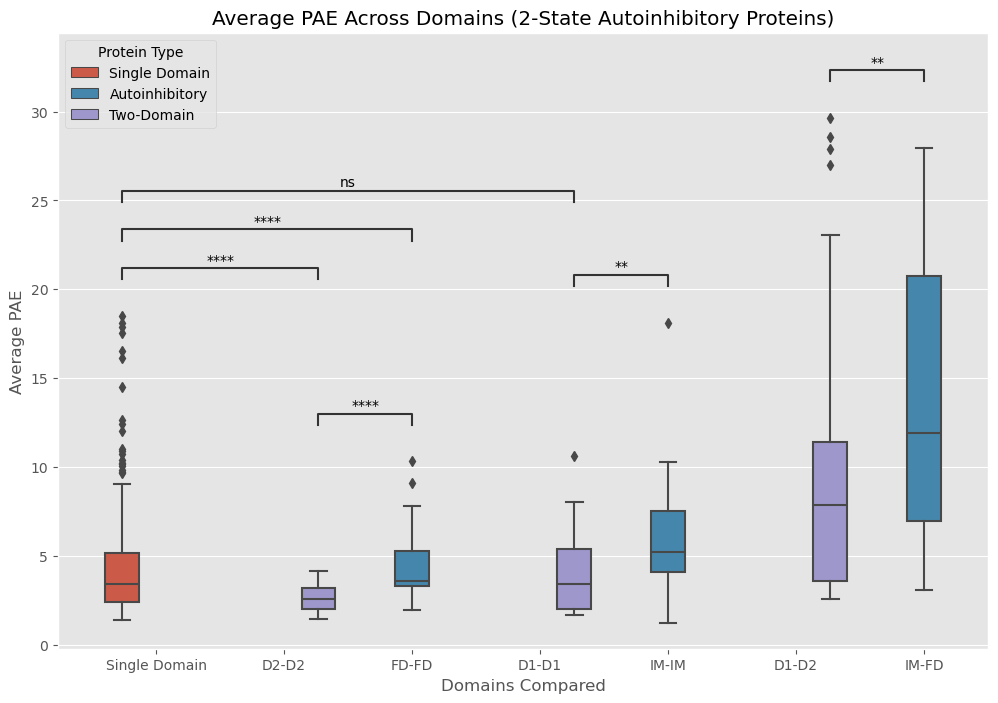

In [81]:
region_order = ['Single Domain', 'D2-D2', 'FD-FD', 'D1-D1', 'IM-IM', 'D1-D2', 'IM-FD']

f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_all2, x='region', y='mean_pae', hue='type', order=region_order, ax=ax)
ax.set_xlabel('Domains Compared')
ax.set_ylabel('Average PAE')
ax.set_title('Average PAE Across Domains (2-State Autoinhibitory Proteins)')
ax.legend(title='Protein Type')

plt.savefig('./project_pipeline/data/figures/auto_sd_md_proteins_pae.png')

# Annotate statistical significance

pairs = [[('Single Domain', 'Single Domain'), ('FD-FD', 'Autoinhibitory')],
         [('Single Domain', 'Single Domain'), ('D2-D2', 'Two-Domain')],
         [('Single Domain', 'Single Domain'), ('D1-D1', 'Two-Domain')],
         [('FD-FD', 'Autoinhibitory'), ('D2-D2', 'Two-Domain')],
         [('IM-IM', 'Autoinhibitory'), ('D1-D1', 'Two-Domain')],
         [('IM-FD', 'Autoinhibitory'), ('D1-D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_all, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="bonferroni")
_, corrected_results = annotator.apply_and_annotate()

Single Domain     258
Two-Domain         54
Autoinhibitory     18
Name: type, dtype: int64


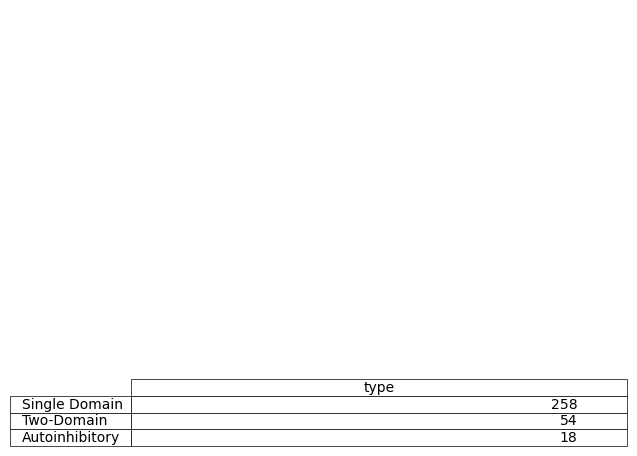

In [77]:
# And a table for these too
subAll = df_all2[['uniprot', 'type']]
subAll = subAll.drop_duplicates()

# Get the number of proteins in each category
counts = subAll['type'].value_counts()
print(counts)

ax = plt.subplot(111, frame_on=False)
table(ax, counts)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)